<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Segmentez-des-clients-d'un-site-e-commerce" data-toc-modified-id="Segmentez-des-clients-d'un-site-e-commerce-1"><strong>Segmentez des clients d'un site e-commerce</strong></a></span></li><li><span><a href="#0.-Imports-and-functions" data-toc-modified-id="0.-Imports-and-functions-2">0. Imports and functions</a></span></li><li><span><a href="#1.-Analyse-de-la-stabilité-des-segments" data-toc-modified-id="1.-Analyse-de-la-stabilité-des-segments-3">1. Analyse de la stabilité des segments</a></span></li></ul></div>

# **Segmentez des clients d'un site e-commerce**

Olist est une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.

Olist souhaite que je fournisse à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Mon objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Je devrai fournir à l’équipe marketing une description actionnable de ma segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

Pour cette mission, Olist a fourni une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients entre septembre 2016 et aout 2018.
A partir de cette base des données, il faut utiliser des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.

Ce notebook est consacré à la détermination de la fréquence nécessaire de mise à jour du modèle de segmentation.

# 0. Imports and functions

In [3]:
%load_ext pycodestyle_magic 
%pycodestyle_on

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def agrégation_df(data):
    """Cette fonction prend en entrée un dataframe,
    effectue une agrégation sur la variable customer_unique_id,
    calcule la récence, supprime ensuite
    la variable order_purchase_timestamp
    et retourne le dataframe ainsi modifié"""
    data = data.groupby('customer_unique_id').agg({
        'order_purchase_timestamp': 'max',
        'payment_value': 'sum',
        'review_score': 'mean',
        'customer_id': 'count'
    })
    data = data.rename(columns={'customer_id':'frequency'})    
    data['recency'] = (data['order_purchase_timestamp'].max() 
                       - data['order_purchase_timestamp']).astype('timedelta64[M]')
    data.drop('order_purchase_timestamp', axis=1, inplace=True)  
    return data

# 1. Analyse de la stabilité des segments

Le modèle de segmentation nécessite des mises à jour régulières car la composition des clusters peut varier au cours du temps. 
Par exemple, les 'nouveaux' clients, ceux qui ont acheté au cours du dernier mois, ne seront plus de nouveaux clients après quelque mois et vont peut-être entrer dans le cluster 'Best Customers' ou dans les clusters des one-timers.

Pour rappel, le modèle de segmentation est un K-Means avec nombre de clusters k = 6.

Afin d'étudier la fréquence optimale de mise à jour, je vais entrainer un premier modèle (model_0)  en utilisant des données dans un intervalle initial, jusqu'à une certaine date t0, et ensuite entrainer 
- Un model_1 avec des données allant jusqu’à t1 = t0 + 1 mois
- Un model_2 avec des données allant jusqu’à t2 = t0 + 2 mois
- Un model_3 avec des données allant jusqu’à t3 = t0 + 3 mois
- etc.
 
Je vais ensuite comparer 
- les clusters identifiés par le model_0 sur les donnes jusqu'à t1 avec les clusters identifiés par model_1 sur les donnes jusqu'à t1 
- les clusters identifiés par le model_0 sur les donnes jusqu'à t2 avec les clusters identifiés par modele_2 sur les donnes jusqu'à t2 
- les clusters identifiés par le model_0 sur les donnes jusqu'à t3 avec les clusters identifiés par modele_3 sur les donnes jusqu'à t3
- etc.

Je vais comparer les clusters en utilisant l'ARI - Adjusted Rand Index - comme métrique (l'indice de Rand est une mesure de similarité entre deux partitions d'un ensemble; plus il est proche de 1, plus les cluster sont similaires).

In [4]:
# lecture données et selection variables
data = pd.read_csv('Data/customers_cleaned_non_grouped')
data['order_purchase_timestamp'] = pd.to_datetime(
    data['order_purchase_timestamp'])
data = data[['order_purchase_timestamp',
             'payment_value',
             'review_score',
             'customer_id',
             'customer_unique_id']]

Afin de déterminer l'intervalle initial sur lequel entrainer le model_0, je vais examiner le nombre de commandes par mois.

In [5]:
# initialisation variable months
data['month'] = data['order_purchase_timestamp'].dt.strftime('%m-%Y')
data['month'] = pd.to_datetime(data['month'])

Text(0, 0.5, 'Nombre de commandes')

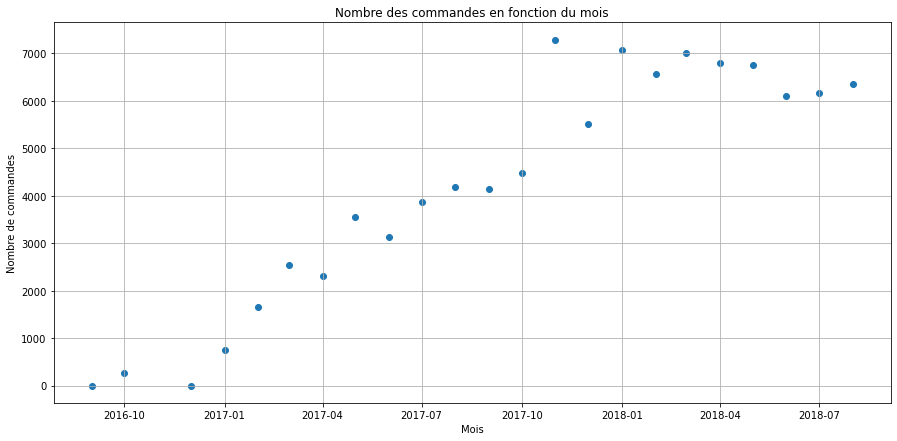

In [6]:
# plot des commandes en fonction du mois
plt.figure(figsize=(15, 7))
plt.scatter(data['month'].value_counts().index,
            data['month'].value_counts().values)
plt.grid()
plt.title('Nombre des commandes en fonction du mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de commandes')

On voit bien qu’en fin 2016 le nombre de commandes était très petit et continu de grandir depuis. Il peut aussi y avoir certains pics de saisonnalité (par exemple, juste avant Noel). Pour lisser les variations saisonnières, je vais prendre 12 mois comme intervalle initial.

La fonction ci-dessous, `evolution_clusters`, prend en entrée un dataframe (les données nettoyées sans agrégation sur `customer unique id`), une date début, une date de fin, un intervalle de temps initial (12 mois par default, comme expliqué ci-dessus) et la fréquence à laquelle on veut comparer les cluster (par exemple, une fois par mois). La date de début de default et la date de fin de default correspondent au minimum et maximum de la variable `order_purchase_timestamp` (2016-09-15 et 2018-08-29, respectivement).

La fonction automatise les pré-traitements des données, fit le model_0 sur les données dans l'intervalle initial, le t0, et prédit les clusters. Ensuite, avec une boucle for, à chaque itération, elle fit un modèle a t0 + fréquence, t0 + 2 X fréquence, t0 + 3 X fréquence, etc. et calcule le ARI score entre les clusters prédits par ces modèles et les clusters prédits par le model_0.

In [7]:
def evolution_clusters(data,
                       initial_interval=12,
                       frequency=1,
                       start_time='2016-09-15',
                       endtime='2018-08-29'):
    """
    Args:
    data: dataframe des données
    initial interval: nombre de mois composant l'intervalle temporel initial
    frequency : fréquence en mois
    start_time: string avec la date de début, format: YYYY-MM-DD
    endtime: string avec la date de fin format: YYYY-MM-DD
    Return:
    Dictionnaire avec les ARI Scores pour chaque itération
    """
    # préparation données model_0
    # sélection données dans l'intervalle initial
    data_0 = data[data['order_purchase_timestamp']
                  < (pd.Timestamp(start_time)
                     + np.timedelta64(initial_interval, 'M'))]
    # agrégation
    data_0 = agrégation_df(data_0)
    # instanciation Quantile Transformer et transformation
    qt = QuantileTransformer(output_distribution='normal')
    data_0[['recency',
            'frequency',
            'review_score']] = qt.fit_transform(data_0[['recency',
                                                        'frequency',
                                                        'review_score']])
    # instanciation Scaler et transformation
    scaler = MinMaxScaler()
    data_0 = scaler.fit_transform(data_0)
    # instanciation model_0 et fit
    model_0 = KMeans(6, random_state=42)
    model_0.fit(data_0)
    # initialisation listes pour stocker les résultats
    iterations = []
    ari_scores = []
    iterations.append(0)
    ari_scores.append(1)
    # date limite du model_0
    max_time = pd.Timestamp(start_time) + np.timedelta64(initial_interval, 'M')
    # boucle d'entrainement des modèles à t+fréquence, t+fréquence*2 etc.
    # et comparaison de clusters
    iteration = 1
    while max_time <= pd.Timestamp(endtime):
        # date limite du modèle
        max_time = max_time + np.timedelta64(frequency, 'M')
        # preparation données
        data_iteration = data[data['order_purchase_timestamp'] < max_time]
        data_iteration = agrégation_df(data_iteration)
        data_iteration[['recency',
                        'frequency',
                        'review_score']] = qt.transform(
            data_iteration[['recency',
                            'frequency',
                            'review_score']])
        data_iteration = scaler.transform(data_iteration)
        # entrainement modèle
        model_iteration = KMeans(6, random_state=42)
        labels_iteration = model_iteration.fit_predict(data_iteration)
        # comparaison avec prédictions du model_0
        ground_truth = model_0.predict(data_iteration)
        ari = adjusted_rand_score(ground_truth, labels_iteration)
        iterations.append(iteration)
        ari_scores.append(ari)
        # itération suivante
        iteration += 1
    return dict(zip(iterations, ari_scores))

In [10]:
# ARI scores
ARI_scores = evolution_clusters(data)

Text(0.5, 1.0, 'ARI scores en fonction du temps')

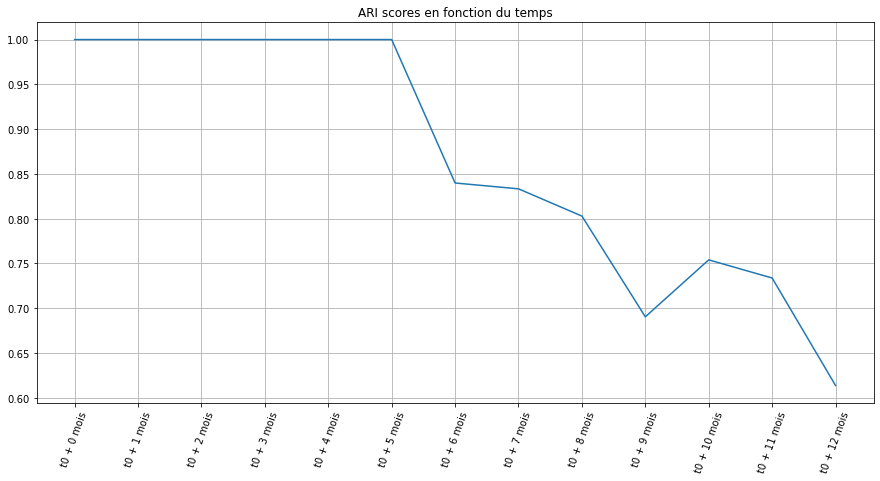

In [12]:
# plot ARI scores en fonction du mois
plt.figure(figsize=(15, 7))
plt.xticks(rotation=70)
plt.xticks(ticks=[i for i in range(13)],
           labels=['t0 + ' + str(i) + ' mois' for i in ARI_scores.keys()])
plt.grid()
plt.plot(ARI_scores.keys(), ARI_scores.values())
plt.title('ARI scores en fonction du temps')

En fixant un seuil de 0.8, il faut mettre à jour le modèle quand l'ARI devient inférieur à ce seuil. Dans le graphique ci-dessus, on peut voir que l'ARI commence à baisse après 5 mois et devient inférieur au seuil après 8 mois. Il peut toujours y avoirs des imprévus et il vaut mieux ne pas attendre les 8 mois pour la mise à jour, mais prendre de l’avance.
**Je propose ainsi une mise à jour tous les 6 mois.**